# Import packages

The 'tensorflow' library is used to do everything machine learning related, such as develop and train machine learning models.

We import the 'unet.py' script as it contains the class "Unet", which represents our machine learning model.

We also import the characteristics of our Unet model from the 'parameters.py' script, which contains details on the number of convolution layers (stackwidth e.g. 1), number of downsampling (stacks e.g. 4), number of kernels convolved at each layer (filters_base e.g. 24), and the size of the kernels (kernel_size e.g. 7x7).

Note: it is important to initialize the Unet with the same parameters as the ones used during training if we want to load a set of trained network weights with compatible dimensions.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from unet import Unet
from parameters import stacks, stackwidth, filters_base, kernel_size, kw

from astropy.io import fits

## Initialize Unet and load trained weights

Here, we initialize a new instance of the Unet model and load it with a set of weights optimized during training.

Our Unet model predicts a clean template of the striped noise that is then used to subtract from the original image.

In [2]:
# Check Unet parameters
print(stacks, stackwidth, filters_base, kernel_size)

4 1 24 7


In [3]:
# Initialize Unet and load weights
model_bkgr = Unet(stacks, stackwidth, filters_base, kernel_size, output_act='tanh', save_path='weights_bkgr', **kw)
model_bkgr.call(np.zeros((1,192,192,1),dtype=np.float32)); 
model_bkgr.load_weights(model_bkgr.save_path + '/weights')

model_strp = Unet(stacks, stackwidth, filters_base, kernel_size, output_act='tanh', save_path='weights_strp', **kw)
model_strp.call(np.zeros((1,192,192,1),dtype=np.float32)); 
model_strp.load_weights(model_strp.save_path + '/weights')

Metal device set to: Apple M1 Pro


2022-09-09 10:15:18.375596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 10:15:18.376059: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Load fits file

In [4]:
filename = 'jw01355009001_02101_00001_nrcblong_rate'
data = fits.open(filename + '.fits')

In [5]:
base_img = data['SCI'].data


# Before feeding the image to the model, it must be expanded in four dimensions (batchsize, height, width, channels)
# Here, we are feeding a single image with a single channel, so (1, height, width, 1)
base_img = base_img[np.newaxis, :, :, np.newaxis]

# Clip data from -1 to 1 like training data
clip_base_img = np.clip(base_img, -1., 1.)


bkgr_img = model_bkgr.call(clip_base_img)

noise_img = clip_base_img - bkgr_img

# Pass the input image to the Unet model to obtain the template
template_img = model_strp.call(noise_img)

# Subtract the template from original image to obtain whitened image
clean_img = base_img - template_img

# Clip clean image for plot
clean_img = np.clip(clean_img, -1., 1.)

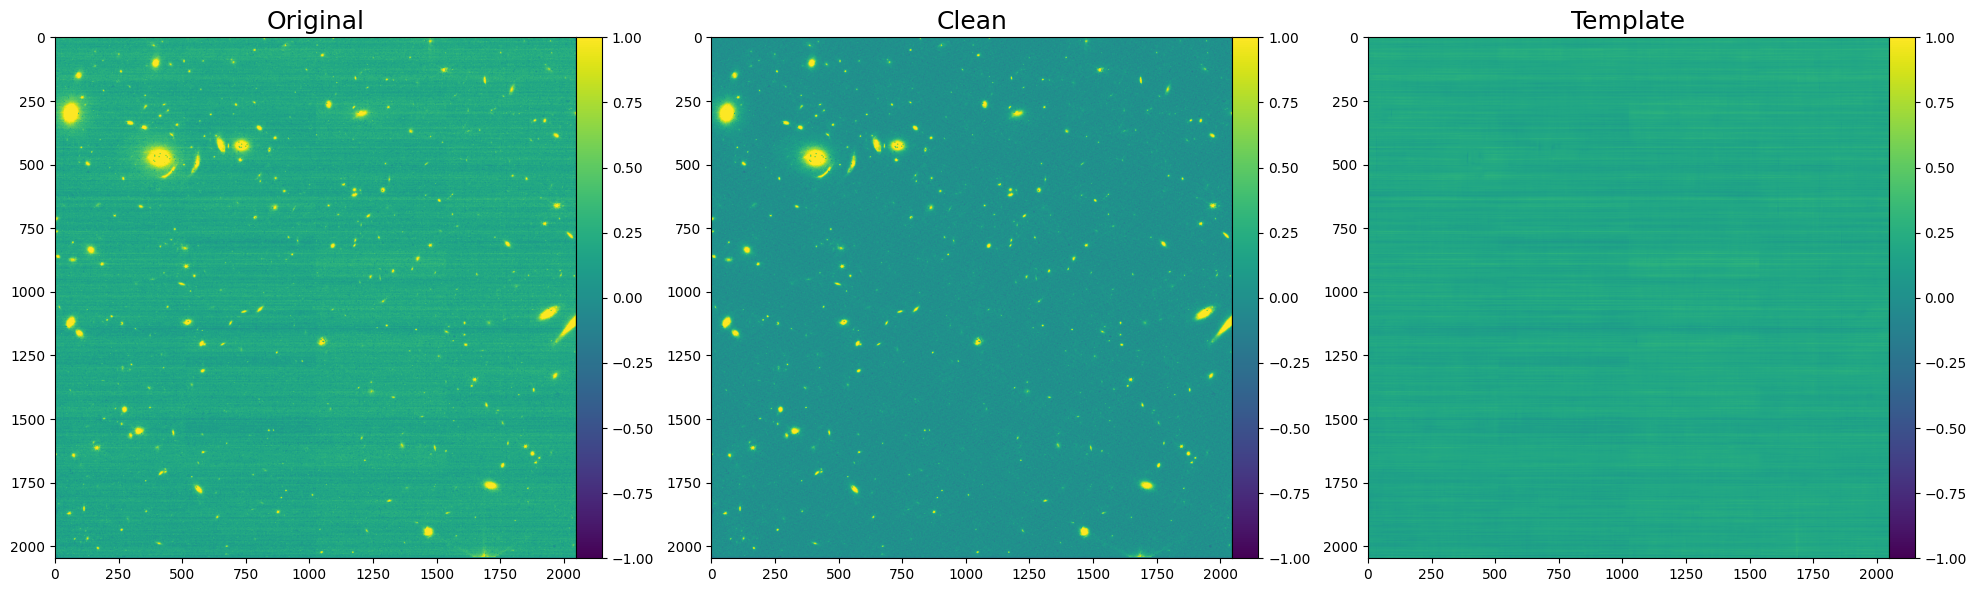

In [9]:
fig = plt.figure(figsize=(8*3, 8))

ax1 = fig.add_subplot(131)
im1 = ax1.imshow(clip_base_img[0,:,:,0], vmin=-1.0, vmax=1.0)
ax1.set_title('Original', fontsize=18)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.0)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(clean_img[0,:,:,0], vmin=-1.0, vmax=1.0)
ax2.set_title('Clean', fontsize=18)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.0)
fig.colorbar(im2, cax=cax, orientation='vertical')

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(template_img[0,:,:,0],vmin=-1.0,vmax=1.0)
ax3.set_title('Template', fontsize=18)

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.0)
fig.colorbar(im3, cax=cax, orientation='vertical')

plt.savefig(filename + '_twopass.png', dpi=200, bbox_inches='tight')
#plt.show()

## Reproduce results grid

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

filenames = ['jw01355016001_02101_00001_nrcb1_cal',
            'jw01355016001_02101_00001_nrcb2_cal',
            'jw01355016001_02101_00001_nrcb3_cal',
            'jw01355016001_02101_00001_nrcb4_cal',
            'jw01355016001_02101_00001_nrcblong_cal',
            'jw01355016001_02101_00002_nrcb1_cal',
            'jw01355016001_02101_00002_nrcb2_cal',
            'jw01355016001_02101_00002_nrcb3_cal',
            'jw01355016001_02103_00001_nrcb1_cal',
            'jw01355016001_02103_00001_nrcb2_cal',
            'jw01355016001_02103_00001_nrcb3_cal',
            'jw01355016001_02103_00001_nrcb4_cal',
            'jw01355016001_02105_00002_nrcblong_cal',
            'jw01355016001_02105_00002_nrcb1_cal',
            'jw01355016001_02105_00002_nrcb3_cal',
            'jw01355016001_02105_00002_nrcb4_cal']

fig, gs = plt.subplots(len(filenames), 3, figsize=(8*3,8*len(filenames)))

for i in range(len(filenames)):
    print(i)
    
    filename = filenames[i]
    
    # Load and preprocess data
    data = fits.open('lvl2/' + filename + '.fits')
    base_img = data['SCI'].data
    base_img = np.tanh(base_img)
    base_img = base_img[np.newaxis, :, :, np.newaxis]
    
    # Obtain template prediction from neural network
    template_img = model.call(base_img)
    clean_img = base_img - template_img

    gs[i, 0].imshow(base_img[0,:,:,0], cmap='gray', vmin=-1.0, vmax=1.0)
    gs[i, 1].imshow(clean_img[0,:,:,0], cmap='gray', vmin=-1.0, vmax=1.0)
    gs[i, 2].imshow(template_img[0,:,:,0], cmap='gray', vmin=-1.0, vmax=1.0)
    

gs[0, 0].set_title('Original', fontsize=22)
gs[0, 1].set_title('Clean', fontsize=22)
gs[0, 2].set_title('Template', fontsize=22)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('results.png', bbox_inches='tight')